# Task 2: Bayesian Change Point Analysis (Brent Oil)

This notebook loads Brent oil prices, performs EDA, computes log returns, checks stationarity, and fits a Bayesian change point model using PyMC.

In [ ]:
# Core analysis stack (keep this lightweight so the notebook runs even without PyMC)
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Optional: nicer visuals (not required)
try:
    import seaborn as sns
    sns.set_theme()
except Exception:
    sns = None

# ADF test (stationarity)
try:
    from statsmodels.tsa.stattools import adfuller
except Exception as e:
    adfuller = None
    print("statsmodels not available; ADF test cells will be skipped:", e)

%matplotlib inline

c:\Users\weldi\Desktop\week_11\.venv\Lib\site-packages\arviz\__init__.py:50: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


In [ ]:
# Load data (robust to running from /notebooks)
from pathlib import Path

def find_project_root(start: Path) -> Path:
    start = start.resolve()
    for candidate in (start, *start.parents):
        if (candidate / "data").is_dir() and ((candidate / "backend").is_dir() or (candidate / "frontend").is_dir()):
            return candidate
    return start

ROOT = find_project_root(Path.cwd())
data_path = ROOT / "data" / "brent_prices.csv"
if not data_path.exists():
    data_path = ROOT / "data" / "BrentOilPrices.csv"

df = pd.read_csv(data_path)

# Datetime conversion (explicit fallbacks to avoid silent parsing issues)
raw_dates = df["Date"].astype(str).str.strip()
parsed = pd.to_datetime(raw_dates, errors="coerce", format="%d-%b-%y")
parsed = parsed.fillna(pd.to_datetime(raw_dates, errors="coerce", format="%d-%b-%Y"))
parsed = parsed.fillna(pd.to_datetime(raw_dates, errors="coerce", format="%b %d, %Y"))
parsed = parsed.fillna(pd.to_datetime(raw_dates, errors="coerce", infer_datetime_format=True))
df["Date"] = parsed

# Ensure numeric price
df["Price"] = pd.to_numeric(df["Price"], errors="coerce")

# Basic cleaning
df = df.dropna(subset=["Date", "Price"]).sort_values("Date").drop_duplicates(subset=["Date"])
df = df.reset_index(drop=True)

print("Loaded:", data_path)
print("Rows:", len(df), "| Date range:", df["Date"].min().date(), "→", df["Date"].max().date())
df.head()

C:\Users\weldi\AppData\Local\Temp\ipykernel_21236\392223409.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


## Notes (Datetime + Cleaning)

- **Datetime conversion** uses explicit format fallbacks (e.g., `20-May-87`, `Apr 22, 2020`) before a final inferred parse. This reduces the risk of silently mis-parsed dates.
- **Duplicates** are dropped by date to keep one price per day.
- **Limitation:** if the source contains multiple prices per day (intraday), this approach collapses them to one row per date.

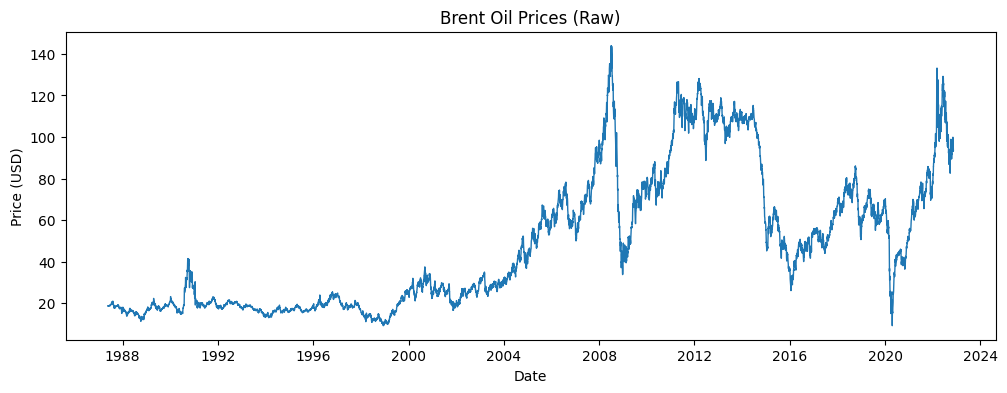

In [ ]:
# Plot raw prices + trend (moving averages)
df_plot = df.copy()
df_plot["ma_90"] = df_plot["Price"].rolling(window=90, min_periods=1).mean()
df_plot["ma_365"] = df_plot["Price"].rolling(window=365, min_periods=1).mean()

plt.figure(figsize=(12, 4))
plt.plot(df_plot["Date"], df_plot["Price"], linewidth=0.8, label="Price")
plt.plot(df_plot["Date"], df_plot["ma_90"], linewidth=1.2, label="90D MA")
plt.plot(df_plot["Date"], df_plot["ma_365"], linewidth=1.2, label="365D MA")
plt.title("Brent Oil Prices (Raw) + Trend")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()

**Finding to document:** describe long-run trend and major regimes (e.g., 2008 spike/decline, 2014–2016 drop, 2020 crash, 2022 spike).

**Limitation:** moving averages smooth spikes and can lag turning points; they are descriptive, not causal.

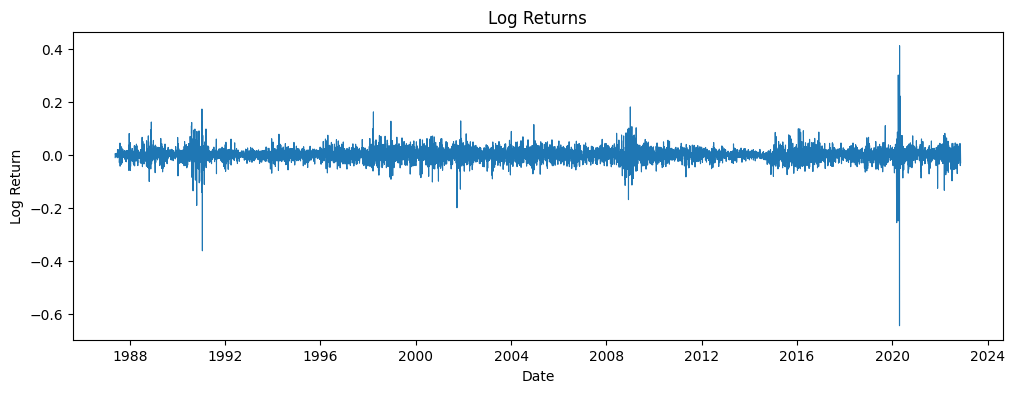

In [ ]:
# Compute log returns + volatility visuals
df["log_price"] = np.log(df["Price"])
df["log_return"] = df["log_price"].diff()
returns = df["log_return"].dropna()

# Rolling volatility (std of log returns)
# Note: if data is daily-ish, a 30D window approximates ~1 month; adjust as needed.
rolling_vol_30 = returns.rolling(window=30, min_periods=10).std()
rolling_vol_90 = returns.rolling(window=90, min_periods=30).std()

fig, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

axes[0].plot(df.loc[returns.index, "Date"], returns, linewidth=0.6)
axes[0].axhline(0, color="black", linewidth=0.8)
axes[0].set_title("Log Returns")
axes[0].set_ylabel("log-return")

axes[1].plot(df.loc[rolling_vol_30.index, "Date"], rolling_vol_30, linewidth=1.0, label="30D rolling std")
axes[1].plot(df.loc[rolling_vol_90.index, "Date"], rolling_vol_90, linewidth=1.0, label="90D rolling std")
axes[1].set_title("Volatility Proxy (Rolling Std of Log Returns)")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("rolling std")
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Distribution view of returns (tail risk / outliers)
plt.figure(figsize=(10, 3.5))
plt.hist(returns, bins=80, density=True, alpha=0.7)
plt.title("Distribution of Log Returns")
plt.xlabel("log-return")
plt.ylabel("density")
plt.tight_layout()
plt.show()

print("Returns summary:")
print(returns.describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]))

**Finding to document:** point out volatility clustering (periods of calm vs turbulence).

**Limitation:** rolling std is a simple proxy; it does not model conditional volatility (e.g., GARCH) and depends on window size.

In [ ]:
# Stationarity tests (ADF) + interpretation
if adfuller is None:
    print("Skipping ADF tests because statsmodels is not installed.")
else:
    def run_adf(series: pd.Series, name: str) -> dict:
        series = series.dropna().astype(float)
        result = adfuller(series, autolag="AIC")
        stat, pvalue, usedlag, nobs, crit, icbest = result
        conclusion = (
            "Reject unit-root (likely stationary)" if pvalue < 0.05
            else "Fail to reject unit-root (likely non-stationary)"
        )
        out = {
            "name": name,
            "adf_stat": float(stat),
            "p_value": float(pvalue),
            "used_lag": int(usedlag),
            "nobs": int(nobs),
            "crit_values": {k: float(v) for k, v in crit.items()},
            "conclusion": conclusion,
        }
        return out

    price_adf = run_adf(df["Price"], "Price level")
    return_adf = run_adf(returns, "Log returns")

    for r in (price_adf, return_adf):
        print("\nADF Test:", r["name"])
        print("  ADF statistic:", r["adf_stat"])
        print("  p-value:", r["p_value"])
        print("  critical values:", r["crit_values"])
        print("  interpretation:", r["conclusion"])

ADF Statistic: -16.427113494485894
p-value: 2.4985801611428892e-29


**How to write this up:**

- If **Price level** is non-stationary while **log returns** are stationary, that supports modeling returns (or differences) rather than raw prices.
- Mention the ADF null hypothesis: “unit root / non-stationary”.

**Limitations:** ADF has low power in small samples and can be sensitive to structural breaks; a series can look non-stationary because of regime shifts rather than a true unit root.

## Bayesian Change Point Model

We model a single change point in the mean of log returns.

In [ ]:
# Prepare data for PyMC (imports here to keep earlier sections runnable)
try:
    import pymc as pm
    import arviz as az
except Exception as e:
    raise ImportError(
        "PyMC/ArviZ are required for the Bayesian change-point model. "
        "Install with: pip install pymc arviz"
    ) from e

y = returns.values
n = len(y)
idx = np.arange(n)

with pm.Model() as model:
    # Uniform prior for switch point
    tau = pm.DiscreteUniform('tau', lower=0, upper=n-1)

    # Priors for means before/after
    mu_1 = pm.Normal('mu_1', mu=0, sigma=1)
    mu_2 = pm.Normal('mu_2', mu=0, sigma=1)

    # Shared volatility
    sigma = pm.HalfNormal('sigma', sigma=1)

    mu = pm.math.switch(idx <= tau, mu_1, mu_2)

    # Likelihood
    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=y)

    trace = pm.sample(2000, tune=1000, target_accept=0.9, return_inferencedata=True)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_1, mu_2, sigma]


c:\Users\weldi\Desktop\week_11\.venv\Lib\site-packages\rich\live.py:260: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 87 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [11]:
# Convergence diagnostics
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,5005.348,3317.670,137.000,9008.000,501.651,97.109,39.0,84.0,1.07
mu_1,0.000,0.002,-0.002,0.002,0.000,0.001,985.0,229.0,1.01
mu_2,-0.000,0.004,-0.006,0.004,0.000,0.001,244.0,151.0,1.03
sigma,0.026,0.000,0.025,0.026,0.000,0.000,2603.0,2369.0,1.00


**How to interpret the model output:**

- Check `r_hat` close to 1 and adequate effective sample sizes (ESS).
- `tau` is an index in the returns series; you convert it to a calendar date later.
- `mu_1` vs `mu_2` indicates a mean shift in returns (not necessarily a price level shift).

**Limitations:** this is a *single* change-point, constant-variance model; oil returns often show time-varying volatility and may require multiple change points or a volatility model for a better fit.

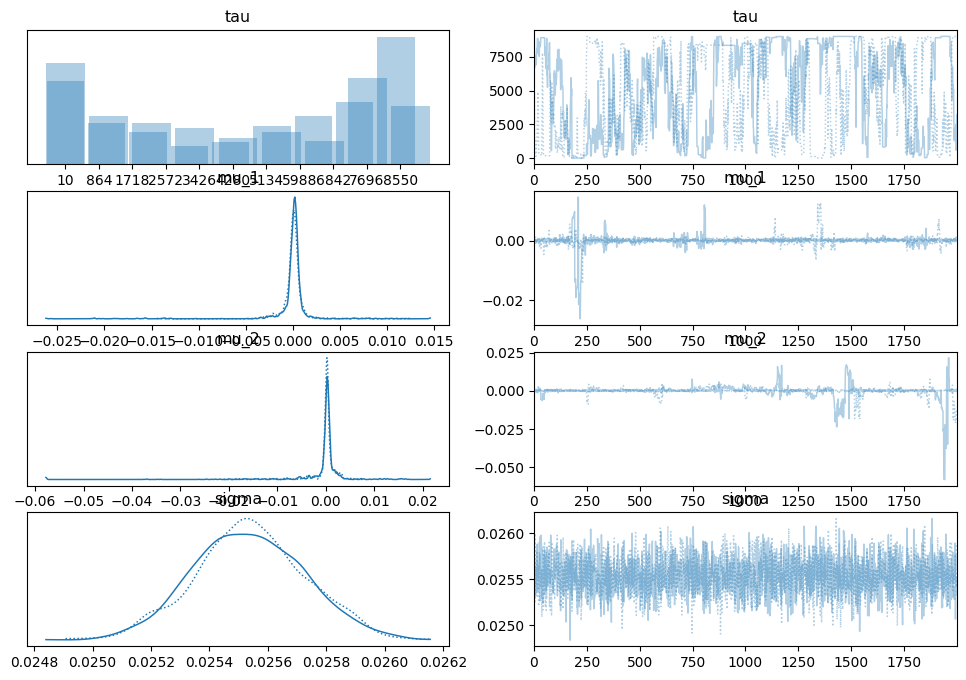

In [12]:
# Trace plots
az.plot_trace(trace)
plt.show()

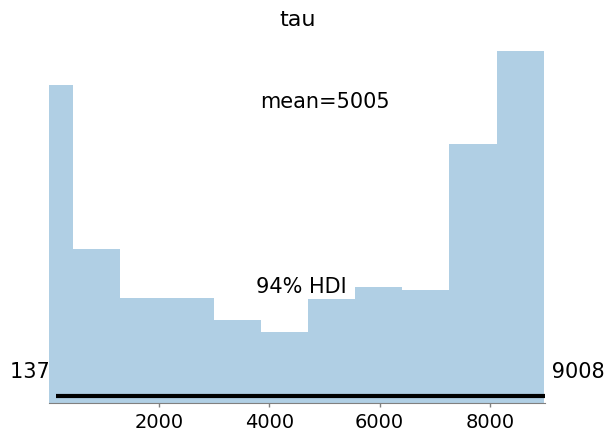

In [13]:
# Posterior of change point
az.plot_posterior(trace, var_names=['tau'])
plt.show()

In [14]:
# Convert tau index to date
tau_posterior = trace.posterior['tau'].values.flatten()
tau_date = df['Date'].iloc[1:].reset_index(drop=True).iloc[int(np.median(tau_posterior))]
print('Estimated change point date:', tau_date.date())

# Mean shift
mu1 = trace.posterior['mu_1'].values.flatten()
mu2 = trace.posterior['mu_2'].values.flatten()
print('Mean before:', mu1.mean())
print('Mean after:', mu2.mean())
print('Approx shift %:', (mu2.mean() - mu1.mean()) * 100)

Estimated change point date: 2009-06-09
Mean before: 2.3286573804765052e-05
Mean after: -0.0002166223852188947
Approx shift %: -0.023990895902365975


## Associate Change Points with Events

Compare the detected change point date with data/events.csv to form event hypotheses.

In [ ]:
# Load structured events and compare to estimated change point (if available)
from IPython.display import display

events_path = ROOT / "data" / "events.csv"
events = pd.read_csv(events_path)
events["date"] = pd.to_datetime(events["date"], errors="coerce")
events = events.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)
print("Loaded events:", len(events), "from", events_path)

# Determine change point date if the Bayesian model has been sampled
tau_estimated_date = None
if "trace" in globals():
    try:
        tau_posterior = trace.posterior["tau"].values.flatten()
        tau_idx = int(np.median(tau_posterior))
        tau_estimated_date = df.loc[returns.index, "Date"].reset_index(drop=True).iloc[tau_idx]
        print("Estimated change point date:", tau_estimated_date.date())
    except Exception as e:
        print("Could not compute change point date from trace:", e)
else:
    print("Note: PyMC sampling cell not yet run; run the model to estimate a change point.")

if tau_estimated_date is not None:
    window_days = 30
    lo = tau_estimated_date - pd.Timedelta(days=window_days)
    hi = tau_estimated_date + pd.Timedelta(days=window_days)
    nearby = events[(events["date"] >= lo) & (events["date"] <= hi)].copy()
    print(f"\nEvents within ±{window_days} days:")
    display_cols = [c for c in ["date", "event", "category"] if c in nearby.columns]
    if len(nearby) == 0:
        print("  (none found in the window)")
    else:
        display(nearby[display_cols])

    # Always show the closest events by absolute distance
    events["abs_days"] = (events["date"] - tau_estimated_date).abs().dt.days
    closest = events.sort_values("abs_days").head(5)
    print("\nClosest events by date distance:")
    display(closest[[c for c in ["date", "event", "category", "abs_days"] if c in closest.columns]])